<img src="header-drifting.png"/>

# Execution du notebook

# Running the notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

This notebook assumes the following tree, for loading data and writing results:

```bash
├───data
│   ├───processed
│   │   ├───df_cust.pkl
│   │   ├───feat_cols.pkl
│   │   ├───n_clusters.pkl
│   │   ├───pca.pkl
│   │   ├───scaler.pkl
│   │   └───X_tsne.pkl
│   │
│   └───raw
│
└───notebooks
    ├───1_exploration.ipynb
    ├───2_segmentation.ipynb
    ├───3_drifting.ipynb
    ├───Ara.png
    ├───Brazil-regions-states.jpg
    ├───header-drifting.png
    ├───header-exploration.png
    ├───header-segmentation.png
    └───TableLinkeage.png
```

Les fichiers `*.pkl` sont issus de l'exécution du notebook `2_segmentation.ipynb`.

The `*.pkl` files come from running the `2_segmentation.ipynb` notebook.

# Initialisation du projet

# Project initialization

In [15]:
# Math & data
import numpy as np
import pandas as pd
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler

# ML
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [7]:
# Personal libraries
from DisplotData import print_debug

In [8]:
DEBUG_LEVEL = 0

# Chargement des données

# Loading data

In [9]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [10]:
file = open(data_processed_dir+'df_cust.pkl','rb')
df_cust = pickle.load(file)
file.close()

file = open(data_processed_dir+'feat_cols.pkl','rb')
feat_cols = pickle.load(file)
file.close()

file = open(data_processed_dir+'n_clusters.pkl','rb')
n_clusters = pickle.load(file)
file.close()

file = open(data_processed_dir+'scaler.pkl','rb')
scaler = pickle.load(file)
file.close()

file = open(data_processed_dir+'pca.pkl','rb')
pca = pickle.load(file)
file.close()

file = open(data_processed_dir+'X_tsne.pkl','rb')
X_tsne = pickle.load(file)
file.close()


# Etude de la période entre deux maintenances

# Study of the period between two maintenances

## Plan d'expériences sur $\Delta$t

## Design of experiments on $\Delta$t

On normalise la colonne de récence avec MinMaxScaler, indépendamment du scaler des autres colonnes

We normalize the recency column with MinMaxScaler, independently of the scaler of the other columns

In [19]:
def select_points_in_period(df, n1, n2, col):
    """Selects samples within a time period.
    
    The period is expressed in "time units" (ex: 1 day, 7 days, 1 second, etc.)
    
    Parameters
    ----------
    df:pandas.DataFrame
        First string to concatenate.
    n1: int
        Start date, in unit of time.
    n2: int
        End date, in unit of time.
    collar: str
        Name of the column expressing the date, in unit of time since the reference date.

    Returns
    -------
    pandas.DataFrame
        Partial dataframe containing only the samples in the period considered.
    """
    selected = (df[col]>=n1) & (df[col]<n2)
    return df.loc[selected]

In [20]:
# Fonction de création des modèles sur les périodes initiales
def create_initial_models(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t, recency_col,
                          nb_m=10):
    """Creates the clustering models for a list of initial time periods.
    
    One model is created per time period (m_max at most). The periods are all of given length (n_UT).
    Important: the scaler used for the recency column is MinMaxScaler, independent of that of the others
    columns.
    
    Parameters
    ----------
    df_cust: pandas.DataFrame
        First string to concatenate.
    feat_cols: list
        List of columns taken into account in the clustering.
    n_clusters: int
        Number of clusters.
    scaler: sklearn.preprocessing
        Scaler to use, outside of the recency column.
    n_UT: int
        Number of time units in the initial period (before extension).
    delta_t: list
        List of initial period increment (extension) values, in time units.
    recency_col:str
        Name of the column carrying the recency in units of time.
    m_max: int, optional
        Maximum number of time periods.

    Returns
    -------
    models_1: dict
        Dictionary of created clustering models, key indexes of initial periods.
    scalers_1: dict
        Dictionary of associated scalers, key indices of initial periods.
    subsets_1: dict
        Dictionary of normalized matrices of each clustering problem, key indices
        initial periods.
    indexes_1: dict
        Dictionary of the indices of the samples intervening in each problem of clustering, of key the indices
        initial periods.
    n_UT_max: int
        Maximum time unit value in the recency column.
    dt_max : int
        Maximum value of time increments.
    """
    # Init
    models_1 = {}
    scalers_1 = {}
    subsets_1 = {}
    indexes_1 = {}
    
    # Highest recency in data
    n_UT_max = df_cust[recency_col].max()
    dt_max = np.array(delta_t).max()
    
    # Maximum start date of periods
    m_max = n_UT_max+1 - n_UT - dt_max    
    print_debug((n_UT_max, n_UT, dt_max), 1, DEBUG_LEVEL)

    print_debug(f"m_max = {m_max}", 1, DEBUG_LEVEL)
    
    # Timestep between the start of the different initial periods
    dt_m = int(m_max/(nb_m-1))
    print_debug(f"dt_m = {dt_m}", 0, DEBUG_LEVEL)

    # Foreach starting point
    for m in range(0, m_max, dt_m):
        print_debug(f"m = {m}", 1, DEBUG_LEVEL)
        
        # Sample selection
        df1 = select_points_in_period(df_cust, m, m+n_UT, recency_col)
        print_debug(f"df1.shape = {df1.shape}", 1, DEBUG_LEVEL)
        print_debug(f"m, m+n_UT+dt = {m, m+n_UT}", 1, DEBUG_LEVEL)
        
        # List of columns other than recency
        feat_cols_but_recency = list(set(feat_cols)-set([recency_col]))
        print_debug(f"feat_cols_but_recency = {feat_cols_but_recency}", 2, DEBUG_LEVEL)
        print_debug(f"df1 = {df1[feat_cols_but_recency]}", 2, DEBUG_LEVEL)
        
        # Matrix
        X1a = df1[feat_cols_but_recency].values
        X1b = df1[[recency_col]]
        # Matrix normalization
        sc = scaler().fit(X1a)
        X1a_sc = sc.transform(X1a)
        if recency_col in feat_cols:
            # We normalize the recency column with MinMaxScaler, independently of the scaler of the other columns
            X1b_sc = MinMaxScaler().fit_transform(X1b)
            X1_sc = np.hstack((X1a_sc, X1b_sc)) # Tout ça pour que ça se passe de la manière pour X2, hein
        else:
            # No recency column
            X1_sc = X1a_sc
            print_debug(f"X1_sc = {X1_sc}", 2, DEBUG_LEVEL)
        
        # Fit one model on this subset
        mdl = KMeans(n_clusters=n_clusters, n_init=10, init='random', random_state=18011975)
        mdl.fit(X1_sc)
        
        # Store the new modele and other data for the current model
        models_1[m]  = mdl
        scalers_1[m] = sc
        subsets_1[m] = X1_sc
        indexes_1[m] = df1.index
        
    return models_1, scalers_1, subsets_1, indexes_1, n_UT_max, dt_max

In [21]:
def study_delta_t(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t, 
                  models_1, scalers_1, n_UT_max, dt_max, recency_col,
                  nb_m=10):
    """Study the time increments, by creating the clustering models in several extended time periods.
    
    One model is created per time period (m_max at most). The extended periods with the list of entered increments.
    The models are compared using the ARI score, averaged over the different initial/extended periods.
    Important: the scaler used for the recency column is MinMaxScaler, independent of the others
    columns scaler.
    
    Parameters
    ----------
    df_cust: pandas.DataFrame
        First string to concatenate.
    feat_cols: list
        List of columns taken into account in the clustering.
    n_clusters: int
        Number of clusters.
    scaler: sklearn.preprocessing
        Scaler to use, outside of the recency column.
    n_UT: int
        Number of time units in the initial period (before extension).
    delta_t: list
        List of initial period increment (extension) values, in time units.
    models_1: dict
        Dictionary of created clustering models, key indexes of initial periods.
    scalers_1: dict
        Dictionary of associated scalers, key indices of initial periods.
    n_UT_max: int
        Maximum time unit value in the recency column.
    dt_max : int
        Maximum value of time increments.
    recency_col:str
        Name of the column carrying the recency in units of time.
    nb_m: int, optional
        Maximum number of initial periods taken for the average.
    verbose: int, optional
        Second string to concatenate.

    Returns
    -------
    models_2: dict
        Dictionary of created clustering models, key indexes of initial periods.
    subsets_2: dict
        Dictionary of normalized matrices of each clustering problem, key indices
        initial periods.
    best_dt: pandas.DataFrame
       Dataframe containing the dt values tested and the corresponding average ARI score.
    """
    # Init
    models_2 = {}
    subsets_2 = {}
    indexes_2 = {}
    mean_ARIs = []
    
    # Maximum start date of periods
    m_max = n_UT_max+1 - n_UT - dt_max    
    
    # Timestep between the beginning of the different initial periods
    dt_m = int(m_max/(nb_m-1))
    print_debug(f"dt_m = {dt_m}", 0, DEBUG_LEVEL)
    
    # Foreach studied deltatime
    for dt in delta_t:
        print_debug(f"------", 1, DEBUG_LEVEL)        
        print_debug(f"dt = {dt}", 0, DEBUG_LEVEL)
        
        scores_ARI = []
        
        # For each starting date
        for m in range(0, m_max, dt_m):
            print_debug(f"m = {m}", 1, DEBUG_LEVEL)
            
            # Sample selection
            df2 = select_points_in_period(df_cust, m, m+n_UT+dt, recency_col)
            print_debug(f"df2.shape = {df2.shape}", 1, DEBUG_LEVEL)
            print_debug(f"m, m+n_UT+dt = {m, m+n_UT+dt}", 1, DEBUG_LEVEL)
            
            # List of columns other than recency
            feat_cols_but_recency = list(set(feat_cols)-set([recency_col]))
            
            # Matrix
            X2a = df2[feat_cols_but_recency].values
            X2b = df2[[recency_col]]
            # Matrix normalisation
            sc = scalers_1[m]
            X2a_sc = sc.transform(X2a)
            if recency_col in feat_cols:
                # We modify the recency so that it is adapted to the new period
                X2b_sc = MinMaxScaler().fit_transform(X2b)
                # Concatenate
                X2_sc = np.hstack((X2a_sc, X2b_sc))
            else:
                X2_sc = X2a_sc
            print_debug(f"X2_sc = {X2_sc}", 2, DEBUG_LEVEL)
        
            # Fit one model on this subset
            mdl2 = KMeans(n_clusters=n_clusters, n_init=10, init='random', random_state=18011975)
            mdl2.fit(X2_sc)
            
            # Store the new modele and other data for the current model
            models_2[m] = mdl2
            subsets_2[m] = X2_sc
            indexes_2[m] = df2.index
            
            # Results with the model #1
            mdl1 = models_1[m]
            labels_with_mdl1 = mdl1.predict(X2_sc)
            print_debug(f"labels_with_mdl1 = {labels_with_mdl1}", 2, DEBUG_LEVEL)

            # Results with the model #2
            labels_with_mdl2 = mdl2.predict(X2_sc)
            print_debug(f"labels_with_mdl2 = {labels_with_mdl2}", 2, DEBUG_LEVEL)
            
            # Result comparison: ARI score
            c = adjusted_rand_score(labels_with_mdl1, labels_with_mdl2)
            print_debug(f"c = {c:.3f}", 1, DEBUG_LEVEL)
            
            # Store the ARI score for averaging
            scores_ARI.append(c)
            pass
        
        # Averaging the ARI scores for this dt
        mean_ARI = np.array(scores_ARI).mean()
        print_debug(f"mean_ARI = {mean_ARI:.3f}", 0, DEBUG_LEVEL)
        mean_ARIs.append([dt, mean_ARI])
        pass
    
    # Output dataframe
    mean_ARIs = pd.DataFrame(mean_ARIs,columns=['dt', 'ARI score'])
    # Sort the best dt
    best_dt = mean_ARIs.sort_values(by='ARI score', ascending=False)
        
    return models_2, subsets_2, indexes_2, best_dt

In [22]:
# Period in UTs (time units)
delta_t = range(0, 181, 15)

# Width of initial periods
n_UT = 181 #365

# Recency column
recency_col = 'order_purchase_recency_01d'

On lance la création des modèles sur les différentes périodes initiales possibles : 

We launch the creation of the models on the different possible initial periods:

In [23]:
models_1, scalers_1, subsets_1, indexes_1, n_UT_max, dt_max = \
    create_initial_models(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t, recency_col, nb_m=10)

dt_m = 27


On lance la création des modèles avec les différents incréments de période (toujours à partir des différentes périodes initiales possibles) :

We launch the creation of the models with the different period increments (always from the different possible initial periods):

In [24]:
models_2, subsets_2, indexes_2, best_dt = study_delta_t(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t,
                                                        models_1, scalers_1, n_UT_max, dt_max, recency_col, nb_m=10)

best_dt

dt_m = 27
dt = 0
mean_ARI = 1.000
dt = 15
mean_ARI = 0.992
dt = 30
mean_ARI = 0.990
dt = 45
mean_ARI = 0.988
dt = 60
mean_ARI = 0.992
dt = 75
mean_ARI = 0.985
dt = 90
mean_ARI = 0.979
dt = 105
mean_ARI = 0.979
dt = 120
mean_ARI = 0.979
dt = 135
mean_ARI = 0.982
dt = 150
mean_ARI = 0.976
dt = 165
mean_ARI = 0.977
dt = 180
mean_ARI = 0.978


,dt,ARI score
0,0,1.000000
4,60,0.992031
1,15,0.991789
2,30,0.990422
3,45,0.988023
5,75,0.985407
9,135,0.982047
6,90,0.979105
7,105,0.978996
8,120,0.978720


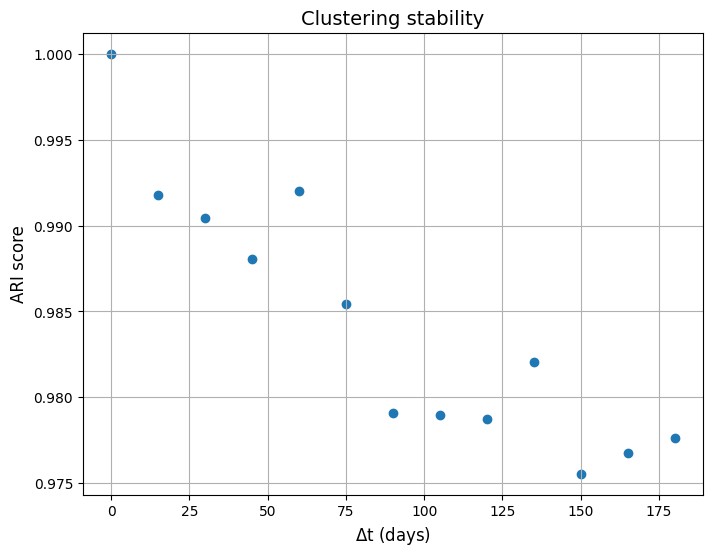

In [25]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure()
plt.scatter(best_dt['dt'], best_dt['ARI score'])
plt.xlabel("$\Delta$t (days)");
plt.ylabel("ARI score");
plt.title("Clustering stability")
plt.grid('on')

Si l'on souhaite conserver **98% de validité** pour le clustering, on peut estimer que **$\Delta$t = 100** provoque un score ARI < 0.98 de manière durable.

Ce résultat sera dépendant de la longueur de la période initiale d'étude : pour n_UT = 30 jours :

If we want to keep **98% validity** for the clustering, we can estimate that **$\Delta$t = 100** causes an ARI score < 0.98 in a sustainable way.

This result will depend on the length of the initial study period: for n_UT = 30 days:

In [26]:
# Period in UTs (time units)
delta_t = range(0, 365, 30)

# Width of initial periods
n_UT = 30

# Recency column
recency_col = 'order_purchase_recency_01d'

On lance la création des modèles sur les différentes périodes initiales possibles : 

We launch the creation of the models on the different possible initial periods:

In [27]:
DEBUG_LEVEL=1

In [28]:
models_1, scalers_1, subsets_1, indexes_1, n_UT_max, dt_max = \
    create_initial_models(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t,
                          recency_col, nb_m=10)

models_2, subsets_2, indexes_2, best_dt = \
    study_delta_t(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t,
                  models_1, scalers_1, n_UT_max, dt_max, recency_col, nb_m=10)

best_dt

(605, 30, 360)
m_max = 216
dt_m = 24
m = 0
df1.shape = (646, 59)
m, m+n_UT+dt = (0, 30)
m = 24
df1.shape = (1672, 59)
m, m+n_UT+dt = (24, 54)
m = 48
df1.shape = (1937, 59)
m, m+n_UT+dt = (48, 78)
m = 72
df1.shape = (2293, 59)
m, m+n_UT+dt = (72, 102)
m = 96
df1.shape = (2343, 59)
m, m+n_UT+dt = (96, 126)
m = 120
df1.shape = (3226, 59)
m, m+n_UT+dt = (120, 150)
m = 144
df1.shape = (3001, 59)
m, m+n_UT+dt = (144, 174)
m = 168
df1.shape = (3150, 59)
m, m+n_UT+dt = (168, 198)
m = 192
df1.shape = (3851, 59)
m, m+n_UT+dt = (192, 222)
dt_m = 24
------
dt = 0
m = 0
df2.shape = (646, 59)
m, m+n_UT+dt = (0, 30)
c = 1.000
m = 24
df2.shape = (1672, 59)
m, m+n_UT+dt = (24, 54)
c = 1.000
m = 48
df2.shape = (1937, 59)
m, m+n_UT+dt = (48, 78)
c = 1.000
m = 72
df2.shape = (2293, 59)
m, m+n_UT+dt = (72, 102)
c = 1.000
m = 96
df2.shape = (2343, 59)
m, m+n_UT+dt = (96, 126)
c = 1.000
m = 120
df2.shape = (3226, 59)
m, m+n_UT+dt = (120, 150)
c = 1.000
m = 144
df2.shape = (3001, 59)
m, m+n_UT+dt = (144, 174)

c = 0.915
m = 48
df2.shape = (56277, 59)
m, m+n_UT+dt = (48, 438)
c = 0.981
m = 72
df2.shape = (60137, 59)
m, m+n_UT+dt = (72, 462)
c = 0.989
m = 96
df2.shape = (63698, 59)
m, m+n_UT+dt = (96, 486)
c = 0.996
m = 120
df2.shape = (67742, 59)
m, m+n_UT+dt = (120, 510)
c = 0.933
m = 144
df2.shape = (69630, 59)
m, m+n_UT+dt = (144, 534)
c = 0.939
m = 168
df2.shape = (71461, 59)
m, m+n_UT+dt = (168, 558)
c = 0.956
m = 192
df2.shape = (74857, 59)
m, m+n_UT+dt = (192, 582)
c = 0.957
mean_ARI = 0.955


,dt,ARI score
0,0,1.000000
1,30,0.979465
7,210,0.972368
10,300,0.967513
8,240,0.967027
3,90,0.966238
9,270,0.959406
6,180,0.958458
4,120,0.957510
5,150,0.956033


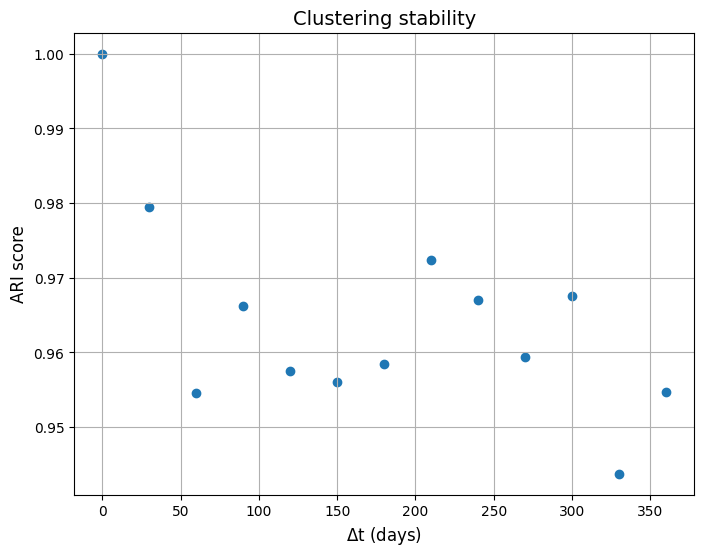

In [29]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure()
plt.scatter(best_dt['dt'], best_dt['ARI score'])
plt.xlabel("$\Delta$t (days)");
plt.ylabel("ARI score");
plt.title("Clustering stability")
plt.grid('on')

La qualité de la clusterisation **remonte après une demi-année**, comme si une certaine **saisonnalité** existait dans les données.

The quality of the clustering **goes up after half a year**, as if a certain **seasonality** existed in the data.

# Comparaison du clustering avant/après $\Delta$t 

# Comparison of clustering before/after $\Delta$t

On incrémente la période suffisamment pour constater une dégradation significative de la segmentation : 

We increment the period enough to see a significant degradation of the segmentation:

In [30]:
delta_t_0 = [200]

On relance la création des modèles avant et après extension, pour vérifier le résultat :  

We restart the creation of the models before and after extension, to check the result:

In [31]:
models_1_0, scalers_1_0, subsets_1_0, indexes_1_0, n_UT_max_0, dt_max_0 = \
    create_initial_models(df_cust, feat_cols, n_clusters,
                          scaler, n_UT, delta_t, recency_col
                          )
models_2_0, subsets_2_0, indexes_2_0, best_dt_0 = \
    study_delta_t(df_cust, feat_cols, n_clusters, scaler, n_UT, delta_t_0,
                  models_1_0, scalers_1_0, n_UT_max_0, dt_max_0, recency_col)

(605, 30, 360)
m_max = 216
dt_m = 24
m = 0
df1.shape = (646, 59)
m, m+n_UT+dt = (0, 30)
m = 24
df1.shape = (1672, 59)
m, m+n_UT+dt = (24, 54)
m = 48
df1.shape = (1937, 59)
m, m+n_UT+dt = (48, 78)
m = 72
df1.shape = (2293, 59)
m, m+n_UT+dt = (72, 102)
m = 96
df1.shape = (2343, 59)
m, m+n_UT+dt = (96, 126)
m = 120
df1.shape = (3226, 59)
m, m+n_UT+dt = (120, 150)
m = 144
df1.shape = (3001, 59)
m, m+n_UT+dt = (144, 174)
m = 168
df1.shape = (3150, 59)
m, m+n_UT+dt = (168, 198)
m = 192
df1.shape = (3851, 59)
m, m+n_UT+dt = (192, 222)
dt_m = 24
------
dt = 200
m = 0
df2.shape = (19278, 59)
m, m+n_UT+dt = (0, 230)
c = 0.913
m = 24
df2.shape = (21886, 59)
m, m+n_UT+dt = (24, 254)
c = 0.964
m = 48
df2.shape = (23863, 59)
m, m+n_UT+dt = (48, 278)
c = 0.982
m = 72
df2.shape = (25722, 59)
m, m+n_UT+dt = (72, 302)
c = 0.986
m = 96
df2.shape = (27677, 59)
m, m+n_UT+dt = (96, 326)
c = 0.965
m = 120
df2.shape = (32975, 59)
m, m+n_UT+dt = (120, 350)
c = 0.986
m = 144
df2.shape = (33986, 59)
m, m+n_UT+dt

In [32]:
best_dt_0

,dt,ARI score
0,200,0.968295


## Visualisation dans le premier plan de l'ACP

## Visualization in the first plane of the PCA

Nous cherchons à visualiser l'évolution de la segmentation après une longue période de temps.

We seek to visualize the evolution of segmentation after a long period of time.

In [33]:
m = 0

In [34]:
X_sc_0  = subsets_2_0[m]
model1   = models_1_0[m]
model2   = models_2_0[m]
lbls1 = model1.predict(X_sc_0)
lbls2 = model2.predict(X_sc_0)
X_proj_0 = pca.transform(X_sc_0)

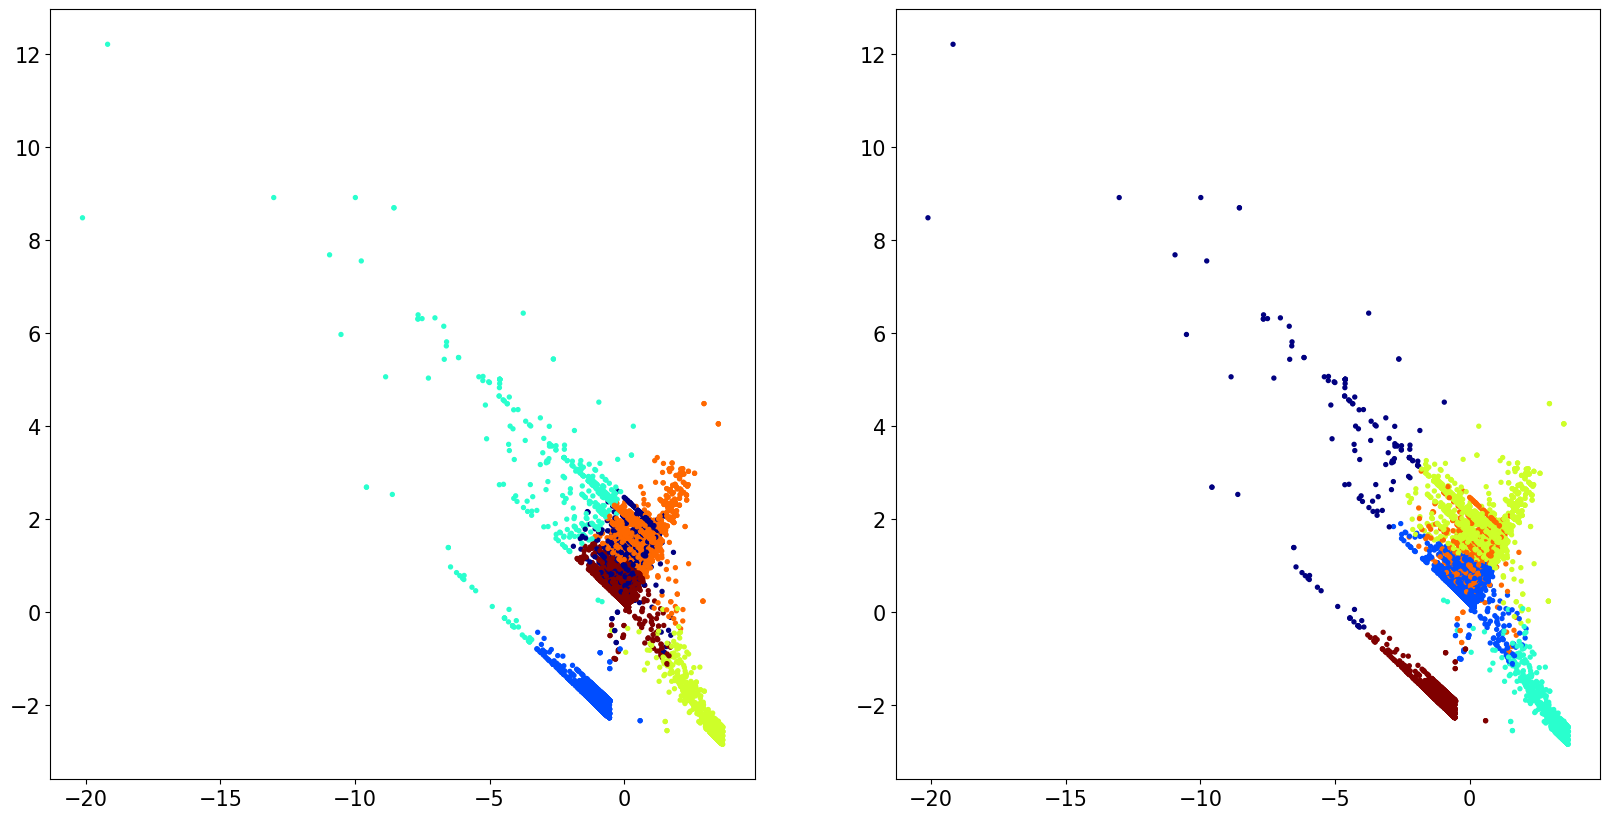

In [41]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X_proj_0[:, 0], X_proj_0[:, 1], c=lbls1, s=8, cmap='jet');
ax2.scatter(X_proj_0[:, 0], X_proj_0[:, 1], c=lbls2, s=8, cmap='jet');

## Visualisation dans le plan du t-SNE

## Visualization in the t-SNE plane

In [37]:
# Studied period
m = 0

In [38]:
X_tsne_0 = pd.DataFrame(X_tsne, columns=['Dim 1', 'Dim 2'])
X_tsne_0 = X_tsne_0.loc[indexes_2[m]]
X_tsne_0 = X_tsne_0.values

In [39]:
cmaps = [
         plt.cm.tab20c,
        ]

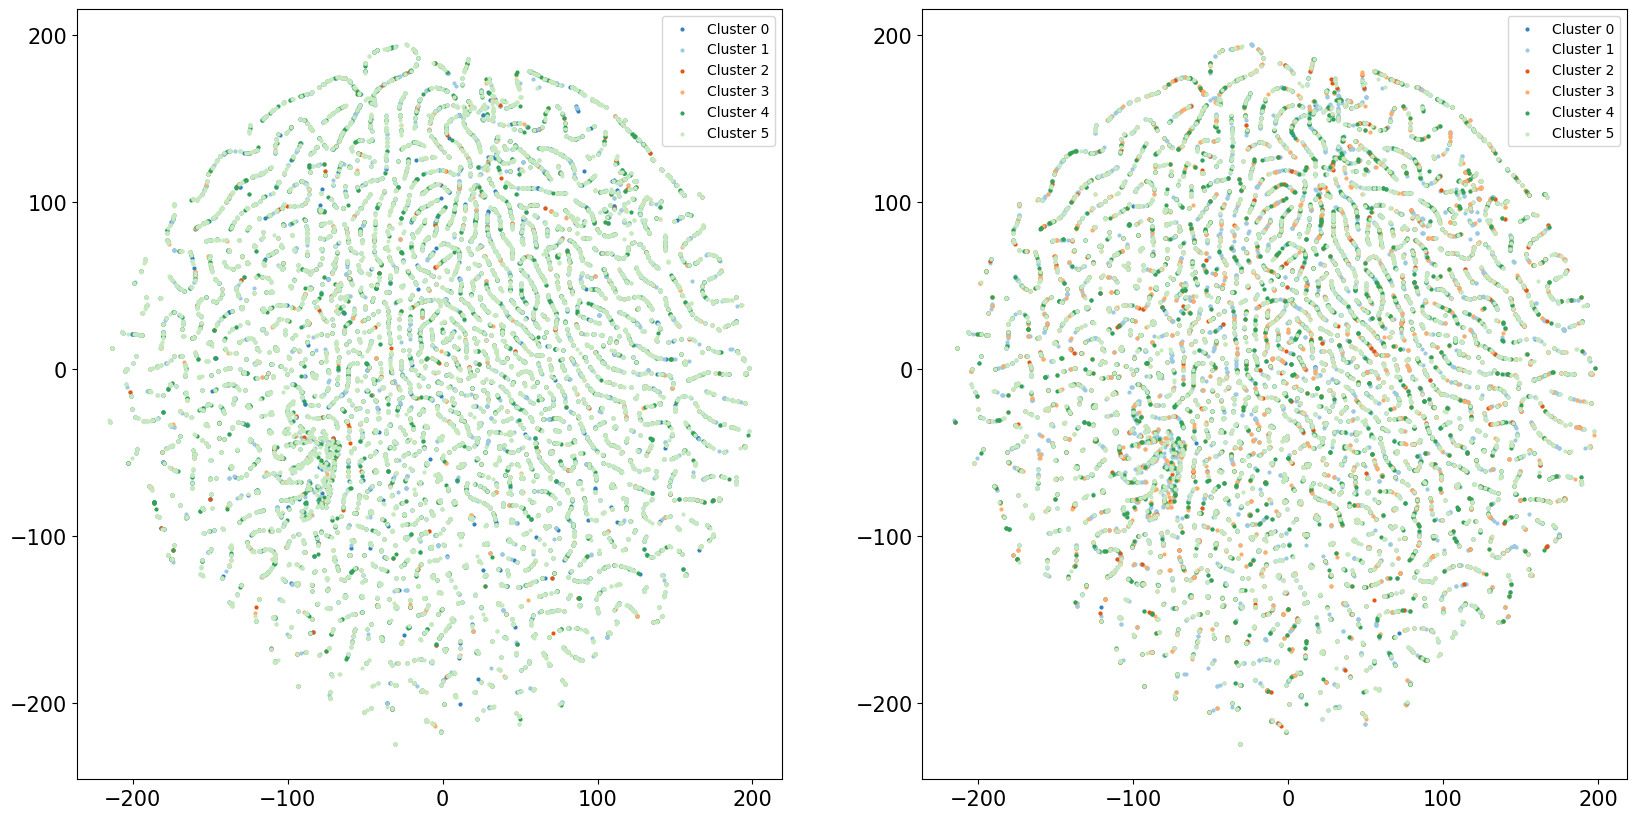

In [40]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
N = 10
for cm in cmaps:
    cmap = cm
    plt.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for label in np.unique(lbls1):
        # Model trained in the first period
        selected1 = np.where(lbls1 == label)
        x = X_tsne_0[selected1, 0]
        y = X_tsne_0[selected1, 1]
        ax1.scatter(x, y, s=4, label=f"Cluster {label}")
        ax1.legend()
        
    for label in np.unique(lbls2):
        # Model trained in the second period
        selected2 = np.where(lbls2 == label)
        x = X_tsne_0[selected2, 0]
        y = X_tsne_0[selected2, 1]
        ax2.scatter(x, y, s=4, label=f"Cluster {label}")
        ax2.legend()

La visualisation du drifting n'est pas concluante.

The visualization of the drifting is not conclusive.